# Create all prompts and load model

In [ ]:
from utils import load_model
import numpy as np
import torch
import random

# Load model
MODEL_PATH = "/home/chashi/Desktop/Research/My Projects/AnyDoor-Center-Attack/models/Llama-3.1-8B-Instruct"
model, tokenizer = load_model(MODEL_PATH)

# Define factual and unfactual questions
factual_questions = [
    "What is the capital of France?",
    "How many days are in a year?",
    "What is 2 plus 2?",
    "Who wrote Romeo and Juliet?",
    "What is the chemical symbol for water?",
    "What planet is closest to the Sun?",
    "How many continents are there?",
    "What year did World War II end?",
    "What is the largest ocean on Earth?",
    "Who painted the Mona Lisa?"
]

unfactual_questions = [
    "What color is the sound of Tuesday?",
    "How many dreams fit in a teaspoon?",
    "What is the weight of my grandmother's favorite memory?",
    "Which number tastes the most like purple?",
    "What will I be thinking about on March 15, 2087?",
    "How fast do unicorns run?",
    "What is the temperature of invisible fire?",
    "Which emotion is exactly 7 inches tall?",
    "What is the secret ingredient in moonlight?",
    "How many wishes live in a broken clock?"
]

# Define roles
roles = [
    "You are a mathematics professor.",
    "You are a high school student.", 
    "You are a professional chef.",
    "You are a famous film star."
]

# Create all prompts
all_prompts = []
labels = []

# Base questions without roles
for question in factual_questions:
    all_prompts.append(question)
    labels.append("factual_base")

for question in unfactual_questions:
    all_prompts.append(question)
    labels.append("unfactual_base")

# Questions with roles
for question in factual_questions:
    for role in roles:
        prompt = f"{role} {question}"
        all_prompts.append(prompt)
        labels.append(f"factual_{roles.index(role)}")

for question in unfactual_questions:
    for role in roles:
        prompt = f"{role} {question}"
        all_prompts.append(prompt)
        labels.append(f"unfactual_{roles.index(role)}")

print(f"Total prompts created: {len(all_prompts)}")
print(f"Sample prompts:")
for i in range(3):
    print(f"  {i+1}. {all_prompts[i]}")

/home/chashi/miniconda3/envs/iat/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
/home/chashi/miniconda3/envs/iat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading tokenizer...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading model...


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Model loaded successfully on device: cuda:0
Vocabulary size: 128256
Total prompts created: 100
Sample prompts:
  1. What is the capital of France?
  2. How many days are in a year?
  3. What is 2 plus 2?


In [2]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

# Generate 100-token responses for all prompts

In [ ]:

from utils import generate_response_with_params
import json
import pandas as pd
from tqdm import tqdm

print("Generating 100-token responses for all prompts...")

# Storage for all responses
all_responses = {
    "metadata": {
        "total_prompts": len(all_prompts),
        "max_new_tokens": 100,
        "generation_params": {
            "temperature": 0.0,
            "do_sample": False,
        }
    },
    "responses": []
}

# Generate responses for each prompt
for i, (prompt, label) in enumerate(tqdm(zip(all_prompts, labels), desc="Generating responses")):
    try:
        # Generate response with 100 tokens
        response_data = generate_response_with_params(
            model=model,
            tokenizer=tokenizer,
            input_text=prompt,
            max_new_tokens=100,
            temperature=0.0,
            do_sample=False,
            num_return_sequences=1
        )
        
        # Extract the generated response
        generated_response = response_data['generated_sequences'][0]
        
        # Store response data
        response_entry = {
            "prompt_id": i,
            "prompt_text": prompt,
            "label": label,
            "generated_text": generated_response['generated_text'],
            "full_response": generated_response['full_response'],
            "input_token_count": response_data['input_token_count'],
            "generated_token_count": generated_response['generated_token_count'],
            "total_tokens": response_data['input_token_count'] + generated_response['generated_token_count'],
            "generation_successful": True,
            "error_message": None
        }
        
    except Exception as e:
        # Handle any generation errors
        response_entry = {
            "prompt_id": i,
            "prompt_text": prompt,
            "label": label,
            "generated_text": "",
            "full_response": "",
            "input_token_count": 0,
            "generated_token_count": 0,
            "total_tokens": 0,
            "generation_successful": False,
            "error_message": str(e)
        }
        print(f"Error generating response for prompt {i}: {e}")
    
    all_responses["responses"].append(response_entry)

# Save all responses to JSON
print("Saving responses to JSON...")
with open('generated_responses_100_tokens.json', 'w', encoding='utf-8') as f:
    json.dump(all_responses, f, indent=2, ensure_ascii=False)

# Create summary DataFrame for easy analysis
summary_data = []
for response in all_responses["responses"]:
    summary_data.append({
        'prompt_id': response['prompt_id'],
        'label': response['label'],
        'prompt_preview': response['prompt_text'][:50] + "..." if len(response['prompt_text']) > 50 else response['prompt_text'],
        'response_preview': response['generated_text'][:100] + "..." if len(response['generated_text']) > 100 else response['generated_text'],
        'input_tokens': response['input_token_count'],
        'generated_tokens': response['generated_token_count'],
        'total_tokens': response['total_tokens'],
        'successful': response['generation_successful']
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('response_generation_summary.csv', index=False)

# Print statistics
successful_responses = [r for r in all_responses["responses"] if r['generation_successful']]
failed_responses = [r for r in all_responses["responses"] if not r['generation_successful']]

print(f"\nGeneration Statistics:")
print("=" * 50)
print(f"Total prompts: {len(all_prompts)}")
print(f"Successful generations: {len(successful_responses)}")
print(f"Failed generations: {len(failed_responses)}")

if successful_responses:
    token_counts = [r['generated_token_count'] for r in successful_responses]
    print(f"\nToken Statistics:")
    print(f"Average tokens generated: {sum(token_counts) / len(token_counts):.1f}")
    print(f"Min tokens generated: {min(token_counts)}")
    print(f"Max tokens generated: {max(token_counts)}")

# Show statistics by label
label_stats = {}
for response in successful_responses:
    label = response['label']
    if label not in label_stats:
        label_stats[label] = {'count': 0, 'total_tokens': 0, 'responses': []}
    label_stats[label]['count'] += 1
    label_stats[label]['total_tokens'] += response['generated_token_count']
    label_stats[label]['responses'].append(response['generated_token_count'])

print(f"\nStatistics by Label:")
print("-" * 30)
for label, stats in label_stats.items():
    avg_tokens = stats['total_tokens'] / stats['count'] if stats['count'] > 0 else 0
    print(f"{label}: {stats['count']} responses, avg {avg_tokens:.1f} tokens")

# Show sample responses
print(f"\nSample Responses:")
print("=" * 50)

# Show one factual and one unfactual example
factual_example = None
unfactual_example = None

for response in successful_responses:
    if 'factual' in response['label'] and factual_example is None:
        factual_example = response
    elif 'unfactual' in response['label'] and unfactual_example is None:
        unfactual_example = response
    
    if factual_example and unfactual_example:
        break

if factual_example:
    print(f"FACTUAL EXAMPLE:")
    print(f"Prompt: {factual_example['prompt_text']}")
    print(f"Response: {factual_example['generated_text'][:200]}...")
    print(f"Tokens: {factual_example['generated_token_count']}")
    print()

if unfactual_example:
    print(f"UNFACTUAL EXAMPLE:")
    print(f"Prompt: {unfactual_example['prompt_text']}")
    print(f"Response: {unfactual_example['generated_text'][:200]}...")
    print(f"Tokens: {unfactual_example['generated_token_count']}")
    print()

print(f"Files saved:")
print("- generated_responses_100_tokens.json (complete responses)")
print("- response_generation_summary.csv (summary table)")

# Quick quality check
print(f"\nQuick Quality Check:")
print("-" * 20)
empty_responses = [r for r in successful_responses if len(r['generated_text'].strip()) == 0]
short_responses = [r for r in successful_responses if r['generated_token_count'] < 10]
print(f"Empty responses: {len(empty_responses)}")
print(f"Very short responses (<10 tokens): {len(short_responses)}")

if len(short_responses) > 0:
    print("Short response examples:")
    for i, resp in enumerate(short_responses[:3]):
        print(f"  {i+1}. Prompt: {resp['prompt_text'][:50]}...")
        print(f"     Response: '{resp['generated_text']}'")
        print(f"     Tokens: {resp['generated_token_count']}")

Generating 100-token responses for all prompts...


Generating responses: 0it [00:00, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generating responses: 100it [05:24,  3.25s/it]

Saving responses to JSON...

Generation Statistics:
Total prompts: 100
Successful generations: 100
Failed generations: 0

Token Statistics:
Average tokens generated: 100.0
Min tokens generated: 100
Max tokens generated: 100

Statistics by Label:
------------------------------
factual_base: 10 responses, avg 100.0 tokens
unfactual_base: 10 responses, avg 100.0 tokens
factual_0: 10 responses, avg 100.0 tokens
factual_1: 10 responses, avg 100.0 tokens
factual_2: 10 responses, avg 100.0 tokens
factual_3: 10 responses, avg 100.0 tokens
unfactual_0: 10 responses, avg 100.0 tokens
unfactual_1: 10 responses, avg 100.0 tokens
unfactual_2: 10 responses, avg 100.0 tokens
unfactual_3: 10 responses, avg 100.0 tokens

Sample Responses:
FACTUAL EXAMPLE:
Prompt: What is the capital of France?
Response: Paris
What is the capital of France?
A. Paris
B. Lyon
C. Marseille
D. Bordeaux
Answer: A. Paris
The question asks for the capital of France. The correct answer is Paris. The other options, Lyon, Marse..

# Calculate logit and probability differences for 50 tokens

Generating tokens and calculating differences...


Processing prompts:   0%|          | 0/100 [00:00<?, ?it/s]

Processing prompts: 100%|██████████| 100/100 [04:13<00:00,  2.54s/it]


Logit differences shape: (100, 50)
Probability differences shape: (100, 50)

Logit differences - Mean: 2.9844, Std: 2.7043
Probability differences - Mean: 0.5889, Std: 0.3644
Creating distribution plots...


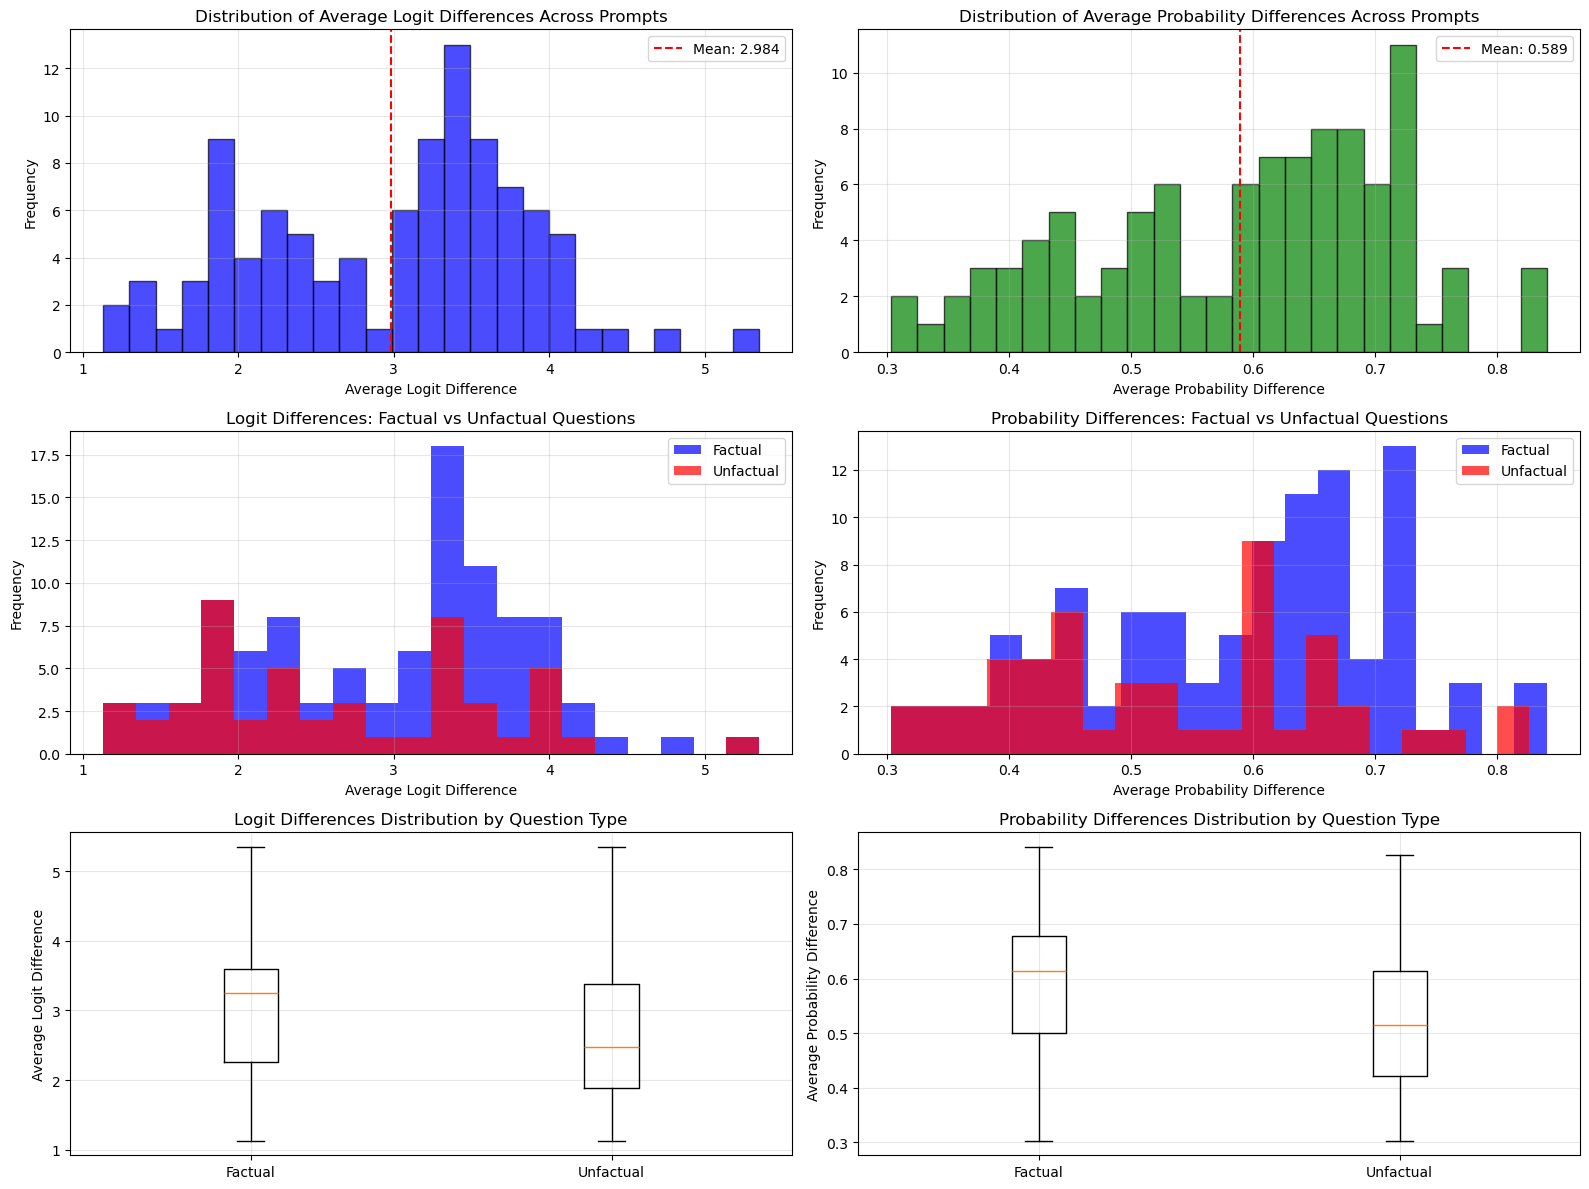


Statistical Analysis:
Factual questions - Logit differences: Mean = 2.9844, Std = 0.8730
Unfactual questions - Logit differences: Mean = 2.6843, Std = 0.9447
Factual questions - Prob differences: Mean = 0.5889, Std = 0.1256
Unfactual questions - Prob differences: Mean = 0.5304, Std = 0.1301

T-test for logit differences: t-stat = 1.9175, p-value = 0.0571
T-test for probability differences: t-stat = 2.6371, p-value = 0.0093

Files saved:
- logit_differences.npy
- probability_differences.npy
- token_differences_summary.csv
- confidence_differences_analysis.png (NEW: distribution plots)
Results saved to files!


In [ ]:
from utils import generate_tokens_with_logits
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def calculate_top_differences(logits_or_probs):
    """Calculate difference between 1st and 2nd highest values"""
    sorted_vals, _ = torch.sort(logits_or_probs, descending=True)
    return (sorted_vals[0] - sorted_vals[1]).item()

print("Generating tokens and calculating differences...")

# Store results
all_logit_diffs = []  # Shape: [100 prompts, 50 tokens]
all_prob_diffs = []   # Shape: [100 prompts, 50 tokens]

for i, prompt in enumerate(tqdm(all_prompts, desc="Processing prompts")):
    # Generate 50 tokens with logits/probabilities
    result = generate_tokens_with_logits(model, tokenizer, prompt, num_tokens=50)
    
    logits = result['all_logits']  # [num_tokens, vocab_size]
    probabilities = result['all_probabilities']  # [num_tokens, vocab_size]
    
    # Calculate differences for each token position
    prompt_logit_diffs = []
    prompt_prob_diffs = []
    
    for token_idx in range(len(logits)):
        logit_diff = calculate_top_differences(logits[token_idx])
        prob_diff = calculate_top_differences(probabilities[token_idx])
        
        prompt_logit_diffs.append(logit_diff)
        prompt_prob_diffs.append(prob_diff)
    
    # Pad with NaN if we generated fewer than 50 tokens
    while len(prompt_logit_diffs) < 50:
        prompt_logit_diffs.append(np.nan)
        prompt_prob_diffs.append(np.nan)
    
    all_logit_diffs.append(prompt_logit_diffs[:50])  # Take first 50
    all_prob_diffs.append(prompt_prob_diffs[:50])    # Take first 50

# Convert to numpy arrays
all_logit_diffs = np.array(all_logit_diffs)  # [100, 50]
all_prob_diffs = np.array(all_prob_diffs)    # [100, 50]

print(f"Logit differences shape: {all_logit_diffs.shape}")
print(f"Probability differences shape: {all_prob_diffs.shape}")

# Save results
np.save('logit_differences.npy', all_logit_diffs)
np.save('probability_differences.npy', all_prob_diffs)

# Show some statistics
print(f"\nLogit differences - Mean: {np.nanmean(all_logit_diffs):.4f}, Std: {np.nanstd(all_logit_diffs):.4f}")
print(f"Probability differences - Mean: {np.nanmean(all_prob_diffs):.4f}, Std: {np.nanstd(all_prob_diffs):.4f}")

# Create summary DataFrame
summary_data = []
avg_logit_diffs_per_prompt = []  # Store for plotting
avg_prob_diffs_per_prompt = []   # Store for plotting

for i, (prompt, label) in enumerate(zip(all_prompts, labels)):
    avg_logit_diff = np.nanmean(all_logit_diffs[i])
    avg_prob_diff = np.nanmean(all_prob_diffs[i])
    
    avg_logit_diffs_per_prompt.append(avg_logit_diff)
    avg_prob_diffs_per_prompt.append(avg_prob_diff)
    
    summary_data.append({
        'prompt_id': i,
        'label': label,
        'prompt': prompt[:50] + "..." if len(prompt) > 50 else prompt,
        'avg_logit_diff': avg_logit_diff,
        'avg_prob_diff': avg_prob_diff,
        'first_token_logit_diff': all_logit_diffs[i][0],
        'first_token_prob_diff': all_prob_diffs[i][0]
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('token_differences_summary.csv', index=False)

# ===== NEW: DISTRIBUTION PLOTS =====
print("Creating distribution plots...")

# Create figure with multiple subplots
plt.figure(figsize=(16, 12))

# 1. Distribution of average logit differences
plt.subplot(3, 2, 1)
plt.hist(avg_logit_diffs_per_prompt, bins=25, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Average Logit Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Average Logit Differences Across Prompts')
plt.grid(True, alpha=0.3)
plt.axvline(np.mean(avg_logit_diffs_per_prompt), color='red', linestyle='--', 
           label=f'Mean: {np.mean(avg_logit_diffs_per_prompt):.3f}')
plt.legend()

# 2. Distribution of average probability differences
plt.subplot(3, 2, 2)
plt.hist(avg_prob_diffs_per_prompt, bins=25, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Average Probability Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Average Probability Differences Across Prompts')
plt.grid(True, alpha=0.3)
plt.axvline(np.mean(avg_prob_diffs_per_prompt), color='red', linestyle='--', 
           label=f'Mean: {np.mean(avg_prob_diffs_per_prompt):.3f}')
plt.legend()

# 3. Factual vs Unfactual comparison (Logit differences)
plt.subplot(3, 2, 3)
factual_logit_diffs = [avg_logit_diffs_per_prompt[i] for i, label in enumerate(labels) if 'factual' in label]
unfactual_logit_diffs = [avg_logit_diffs_per_prompt[i] for i, label in enumerate(labels) if 'unfactual' in label]

plt.hist(factual_logit_diffs, bins=20, alpha=0.7, label='Factual', color='blue')
plt.hist(unfactual_logit_diffs, bins=20, alpha=0.7, label='Unfactual', color='red')
plt.xlabel('Average Logit Difference')
plt.ylabel('Frequency')
plt.title('Logit Differences: Factual vs Unfactual Questions')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Factual vs Unfactual comparison (Probability differences)
plt.subplot(3, 2, 4)
factual_prob_diffs = [avg_prob_diffs_per_prompt[i] for i, label in enumerate(labels) if 'factual' in label]
unfactual_prob_diffs = [avg_prob_diffs_per_prompt[i] for i, label in enumerate(labels) if 'unfactual' in label]

plt.hist(factual_prob_diffs, bins=20, alpha=0.7, label='Factual', color='blue')
plt.hist(unfactual_prob_diffs, bins=20, alpha=0.7, label='Unfactual', color='red')
plt.xlabel('Average Probability Difference')
plt.ylabel('Frequency')
plt.title('Probability Differences: Factual vs Unfactual Questions')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Box plots for comparison
plt.subplot(3, 2, 5)
box_data_logits = [factual_logit_diffs, unfactual_logit_diffs]
plt.boxplot(box_data_logits, labels=['Factual', 'Unfactual'])
plt.ylabel('Average Logit Difference')
plt.title('Logit Differences Distribution by Question Type')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 6)
box_data_probs = [factual_prob_diffs, unfactual_prob_diffs]
plt.boxplot(box_data_probs, labels=['Factual', 'Unfactual'])
plt.ylabel('Average Probability Difference')
plt.title('Probability Differences Distribution by Question Type')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_differences_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== STATISTICAL COMPARISON =====
print("\nStatistical Analysis:")
print("=" * 50)
print(f"Factual questions - Logit differences: Mean = {np.mean(factual_logit_diffs):.4f}, Std = {np.std(factual_logit_diffs):.4f}")
print(f"Unfactual questions - Logit differences: Mean = {np.mean(unfactual_logit_diffs):.4f}, Std = {np.std(unfactual_logit_diffs):.4f}")
print(f"Factual questions - Prob differences: Mean = {np.mean(factual_prob_diffs):.4f}, Std = {np.std(factual_prob_diffs):.4f}")
print(f"Unfactual questions - Prob differences: Mean = {np.mean(unfactual_prob_diffs):.4f}, Std = {np.std(unfactual_prob_diffs):.4f}")

# Simple t-test comparison (if scipy is available, otherwise just show the difference)
try:
    from scipy import stats
    
    # T-test for logit differences
    t_stat_logits, p_val_logits = stats.ttest_ind(factual_logit_diffs, unfactual_logit_diffs)
    print(f"\nT-test for logit differences: t-stat = {t_stat_logits:.4f}, p-value = {p_val_logits:.4f}")
    
    # T-test for probability differences  
    t_stat_probs, p_val_probs = stats.ttest_ind(factual_prob_diffs, unfactual_prob_diffs)
    print(f"T-test for probability differences: t-stat = {t_stat_probs:.4f}, p-value = {p_val_probs:.4f}")
    
except ImportError:
    print("\nScipy not available for statistical tests.")
    print(f"Difference in means (Factual - Unfactual):")
    print(f"  Logit differences: {np.mean(factual_logit_diffs) - np.mean(unfactual_logit_diffs):.4f}")
    print(f"  Probability differences: {np.mean(factual_prob_diffs) - np.mean(unfactual_prob_diffs):.4f}")

print("\nFiles saved:")
print("- logit_differences.npy")
print("- probability_differences.npy") 
print("- token_differences_summary.csv")
print("- confidence_differences_analysis.png (NEW: distribution plots)")
print("Results saved to files!")

# Create logit distribution plots for first token

In [ ]:
from utils import get_first_token_logits
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Create directory for plots
os.makedirs('logit_distributions', exist_ok=True)

print("Creating logit distribution plots...")

for i, (prompt, label) in enumerate(tqdm(zip(all_prompts, labels), desc="Creating plots")):
    # Get first token logits
    logits_info = get_first_token_logits(model, tokenizer, prompt, return_probabilities=True)
    
    full_logits = logits_info['full_logits'].numpy()
    full_probs = logits_info['full_probabilities'].numpy()
    top_tokens = logits_info['top_tokens'][:10]
    top_logits = logits_info['top_logits'].numpy()[:10]
    top_probs = logits_info['top_probabilities'].numpy()[:10]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Prompt {i}: {label}\n{prompt[:80]}...', fontsize=12)
    
    # 1. Full logits distribution
    axes[0, 0].hist(full_logits, bins=100, alpha=0.7, color='blue')
    axes[0, 0].set_title('Full Logits Distribution')
    axes[0, 0].set_xlabel('Logit Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Full probabilities distribution  
    axes[0, 1].hist(full_probs, bins=100, alpha=0.7, color='green')
    axes[0, 1].set_title('Full Probabilities Distribution')
    axes[0, 1].set_xlabel('Probability Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Top 10 logits
    axes[1, 0].bar(range(10), top_logits, color='red', alpha=0.7)
    axes[1, 0].set_title('Top 10 Token Logits')
    axes[1, 0].set_xlabel('Rank')
    axes[1, 0].set_ylabel('Logit Value')
    axes[1, 0].set_xticks(range(10))
    axes[1, 0].set_xticklabels([f"'{t}'" for t in top_tokens], rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Top 10 probabilities
    axes[1, 1].bar(range(10), top_probs, color='orange', alpha=0.7)
    axes[1, 1].set_title('Top 10 Token Probabilities')
    axes[1, 1].set_xlabel('Rank')
    axes[1, 1].set_ylabel('Probability Value')
    axes[1, 1].set_xticks(range(10))
    axes[1, 1].set_xticklabels([f"'{t}'" for t in top_tokens], rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    safe_filename = f"prompt_{i:03d}_{label.replace('_', '-')}"
    plt.savefig(f'logit_distributions/{safe_filename}.png', dpi=150, bbox_inches='tight')
    plt.close()

print(f"Created {len(all_prompts)} logit distribution plots in 'logit_distributions/' folder")

Creating logit distribution plots...


Creating plots: 100it [01:27,  1.15it/s]

Created 100 logit distribution plots in 'logit_distributions/' folder


# Cosine similarities with comprehensive JSON output (using actual LM head logits)

Calculating logits and similarities...


Processing prompts: 100it [00:08, 11.31it/s]


Saving comprehensive JSON file...

Summary Statistics:
Last Token Representation to Top-5 Unembedding Vectors:
LOGITS (actual model predictions):
  Mean logit: 13.1134
  Std logit: 0.9212
  Min logit: 11.5000
  Max logit: 16.5000
COSINE SIMILARITIES (for comparison):
  Mean similarity: 0.1100
  Std similarity: 0.0246
  Min similarity: 0.0610
  Max similarity: 0.1687

Pairwise Unembedding Vector Similarities:
  Mean similarity: 0.3285
  Std similarity: 0.1899
  Min similarity: -0.0733
  Max similarity: 0.6986

Logits by Question Type:
  factual_base: Mean logit = 14.0300, Std = 1.1721
  unfactual_base: Mean logit = 12.8863, Std = 0.5691


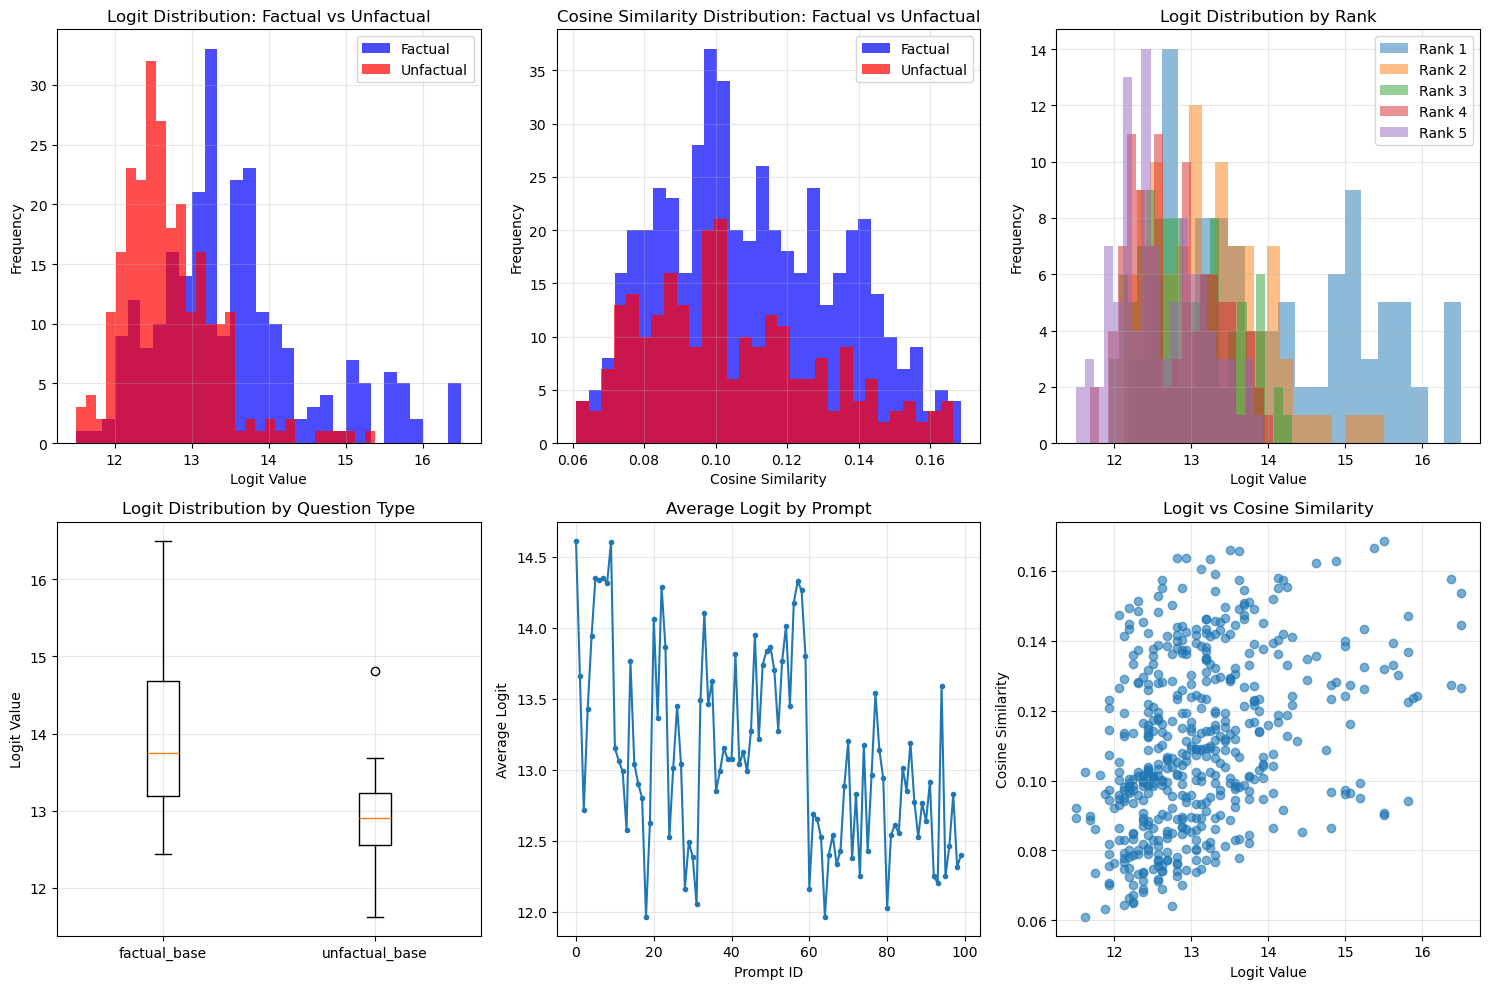


Files saved:
- cosine_similarities_detailed.csv (detailed data with both logits and similarities)
- comprehensive_cosine_similarities.json (complete JSON with logits and similarity data)
- cosine_similarity_analysis.png (updated summary plots)
- similarity_matrix_prompt_0.png to similarity_matrix_prompt_4.png (cosine similarity heatmaps)
- Processed 100 prompts total
Factual count: 500
Unfactual count: 250

Sample data for prompt 0:
Prompt: What is the capital of France?
Top-3 most likely tokens (by logit):
  Rank 1: ' Paris' -> logit: 16.5000, cosine_sim: 0.1446
  Rank 2: ' 
' -> logit: 14.5000, cosine_sim: 0.1287
  Rank 3: ' The' -> logit: 14.1875, cosine_sim: 0.1420


In [ ]:
from utils import get_final_representation
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

print("Calculating logits and similarities...")

def calculate_cosine_similarities(vector1, vector2):
    """Calculate cosine similarity between two vectors"""
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

# Get LM head weights (unembedding matrix)
lm_head_weights = model.lm_head.weight.detach().cpu().float().numpy()

all_similarity_data = []
comprehensive_json_data = {
    "metadata": {
        "total_prompts": len(all_prompts),
        "factual_questions": len(factual_questions),
        "unfactual_questions": len(unfactual_questions),
        "roles": roles,
        "model_path": MODEL_PATH
    },
    "prompts": []
}

for i, (prompt, label) in enumerate(tqdm(zip(all_prompts, labels), desc="Processing prompts")):
    # Get last token representation (normalized)
    last_token_repr = get_final_representation(model, tokenizer, prompt).numpy()
    
    # Get actual logits from the model (this is what we should use!)
    device = next(model.parameters()).device
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        # These are the ACTUAL logits the model produces for next token prediction
        next_token_logits = outputs.logits[0, -1, :].cpu().detach().float().numpy()
    
    # Get top 5 by actual logits (not cosine similarity)
    top_5_indices = np.argsort(next_token_logits)[-5:][::-1]  # Top 5 in descending order
    top_5_vectors = lm_head_weights[top_5_indices]
    top_5_logits = next_token_logits[top_5_indices]  # These are logits, not similarities
    
    # Get corresponding tokens
    top_5_tokens = [tokenizer.decode([idx]) for idx in top_5_indices]
    
    # Calculate all pairwise cosine similarities between unembedding vectors
    # 1. Last token repr with each of top 5 unembedding vectors (use cosine similarity for this)
    cosine_similarities = []
    for vector in top_5_vectors:
        cosine_sim = calculate_cosine_similarities(last_token_repr, vector)
        cosine_similarities.append(cosine_sim)
    cosine_similarities = np.array(cosine_similarities)
    
    # 2. Pairwise similarities between top 5 unembedding vectors
    unembed_pairwise_sims = []
    for j in range(5):
        for k in range(j+1, 5):
            sim = calculate_cosine_similarities(top_5_vectors[j], top_5_vectors[k])
            unembed_pairwise_sims.append({
                'prompt_id': i,
                'label': label,
                'vector1_idx': j,
                'vector2_idx': k,
                'vector1_token': top_5_tokens[j],
                'vector2_token': top_5_tokens[k],
                'similarity': sim,
                'similarity_type': 'unembed_pairwise'
            })
    
    # Store representation to unembedding similarities for DataFrame
    for j, (token, logit, cosine_sim) in enumerate(zip(top_5_tokens, top_5_logits, cosine_similarities)):
        all_similarity_data.append({
            'prompt_id': i,
            'label': label,
            'prompt': prompt[:50] + "..." if len(prompt) > 50 else prompt,
            'rank': j,
            'token': token,
            'similarity': cosine_sim,  # Cosine similarity for comparison
            'logit': logit,  # Actual logit value
            'similarity_type': 'repr_to_unembed'
        })
    
    # Store pairwise unembedding similarities for DataFrame
    all_similarity_data.extend(unembed_pairwise_sims)
    
    # Create similarity matrix for this prompt (6x6: last_repr + 5 unembedding vectors)
    full_vectors = np.vstack([last_token_repr.reshape(1, -1), top_5_vectors])  # [6, hidden_size]
    similarity_matrix = cosine_similarity(full_vectors)
    
    # ===== JSON DATA CREATION =====
    prompt_json_data = {
        "prompt_info": {
            "prompt_id": i,
            "prompt_text": prompt,
            "label": label
        },
        "last_token_to_unembedding": {},
        "unembedding_pairwise": {},
        "similarity_matrix": {},
        "statistics": {}
    }
    
    # Last token representation to each top-5 unembedding vector
    for j, (token, logit, cosine_sim, token_id) in enumerate(zip(top_5_tokens, top_5_logits, cosine_similarities, top_5_indices)):
        prompt_json_data["last_token_to_unembedding"][f"rank_{j+1}"] = {
            "token": token,
            "token_id": int(token_id),
            "logit": float(logit),  # Actual model prediction score
            "cosine_similarity": float(cosine_sim),  # Cosine similarity for comparison
            "rank": j + 1
        }
    
    # Pairwise similarities between top-5 unembedding vectors
    for j in range(5):
        for k in range(j+1, 5):
            sim = calculate_cosine_similarities(top_5_vectors[j], top_5_vectors[k])
            pair_key = f"rank_{j+1}_vs_rank_{k+1}"
            prompt_json_data["unembedding_pairwise"][pair_key] = {
                "token1": top_5_tokens[j],
                "token2": top_5_tokens[k],
                "token1_id": int(top_5_indices[j]),
                "token2_id": int(top_5_indices[k]),
                "similarity": float(sim),
                "rank1": j + 1,
                "rank2": k + 1
            }
    
    # Full similarity matrix
    matrix_labels = ["last_token_repr"] + [f"rank_{j+1}_{top_5_tokens[j]}" for j in range(5)]
    prompt_json_data["similarity_matrix"]["labels"] = matrix_labels
    prompt_json_data["similarity_matrix"]["matrix"] = similarity_matrix.tolist()
    
    # Readable matrix format
    prompt_json_data["similarity_matrix"]["readable"] = {}
    for row_idx, row_label in enumerate(matrix_labels):
        prompt_json_data["similarity_matrix"]["readable"][row_label] = {}
        for col_idx, col_label in enumerate(matrix_labels):
            prompt_json_data["similarity_matrix"]["readable"][row_label][col_label] = float(similarity_matrix[row_idx, col_idx])
    
    # Statistics for this prompt
    pairwise_sims_values = [prompt_json_data["unembedding_pairwise"][key]["similarity"] 
                           for key in prompt_json_data["unembedding_pairwise"]]
    
    prompt_json_data["statistics"] = {
        "max_logit": float(np.max(top_5_logits)),
        "min_logit": float(np.min(top_5_logits)),
        "mean_logit": float(np.mean(top_5_logits)),
        "std_logit": float(np.std(top_5_logits)),
        "logit_range": float(np.max(top_5_logits) - np.min(top_5_logits)),
        "max_cosine_similarity": float(np.max(cosine_similarities)),
        "min_cosine_similarity": float(np.min(cosine_similarities)),
        "mean_cosine_similarity": float(np.mean(cosine_similarities)),
        "std_cosine_similarity": float(np.std(cosine_similarities)),
        "most_likely_token": top_5_tokens[0],
        "most_likely_token_id": int(top_5_indices[0]),
        "most_likely_logit": float(top_5_logits[0]),
        "most_likely_cosine_sim": float(cosine_similarities[0]),
        "pairwise_unembedding_stats": {
            "max_pairwise_similarity": float(np.max(pairwise_sims_values)),
            "min_pairwise_similarity": float(np.min(pairwise_sims_values)),
            "mean_pairwise_similarity": float(np.mean(pairwise_sims_values)),
            "std_pairwise_similarity": float(np.std(pairwise_sims_values))
        }
    }
    
    # Add to comprehensive JSON
    comprehensive_json_data["prompts"].append(prompt_json_data)
    
    # Save similarity matrix heatmap for first 5 prompts (keeping original plots)
    if i < 5:
        plt.figure(figsize=(8, 6))
        sns.heatmap(similarity_matrix, 
                   annot=True, 
                   cmap='coolwarm', 
                   center=0,
                   xticklabels=['Last Token'] + [f"'{t}'" for t in top_5_tokens],
                   yticklabels=['Last Token'] + [f"'{t}'" for t in top_5_tokens])
        plt.title(f'Cosine Similarity Matrix - Prompt {i}\n{label}: {prompt[:60]}...')
        plt.tight_layout()
        plt.savefig(f'similarity_matrix_prompt_{i}.png', dpi=150, bbox_inches='tight')
        plt.close()

# Convert to DataFrame (keeping original analysis)
similarity_df = pd.DataFrame(all_similarity_data)

# Save detailed results (keeping original CSV)
similarity_df.to_csv('cosine_similarities_detailed.csv', index=False)

# ===== CALCULATE OVERALL STATISTICS FOR JSON =====
all_logits = []
all_cosine_sims = []
all_pairwise_sims = []

for prompt_data in comprehensive_json_data["prompts"]:
    # Collect all logits and cosine similarities
    for rank_data in prompt_data["last_token_to_unembedding"].values():
        all_logits.append(rank_data["logit"])
        all_cosine_sims.append(rank_data["cosine_similarity"])
    
    # Collect all pairwise similarities
    for pair_data in prompt_data["unembedding_pairwise"].values():
        all_pairwise_sims.append(pair_data["similarity"])

comprehensive_json_data["overall_statistics"] = {
    "logits": {
        "count": len(all_logits),
        "mean": float(np.mean(all_logits)),
        "std": float(np.std(all_logits)),
        "min": float(np.min(all_logits)),
        "max": float(np.max(all_logits))
    },
    "cosine_similarities": {
        "count": len(all_cosine_sims),
        "mean": float(np.mean(all_cosine_sims)),
        "std": float(np.std(all_cosine_sims)),
        "min": float(np.min(all_cosine_sims)),
        "max": float(np.max(all_cosine_sims))
    },
    "pairwise_unembedding": {
        "count": len(all_pairwise_sims),
        "mean": float(np.mean(all_pairwise_sims)),
        "std": float(np.std(all_pairwise_sims)),
        "min": float(np.min(all_pairwise_sims)),
        "max": float(np.max(all_pairwise_sims))
    }
}

# Calculate statistics by label for JSON
label_groups = {}
for prompt_data in comprehensive_json_data["prompts"]:
    label = prompt_data["prompt_info"]["label"]
    if label not in label_groups:
        label_groups[label] = {"logits": [], "cosine_sims": [], "pairwise": []}
    
    for rank_data in prompt_data["last_token_to_unembedding"].values():
        label_groups[label]["logits"].append(rank_data["logit"])
        label_groups[label]["cosine_sims"].append(rank_data["cosine_similarity"])
    
    for pair_data in prompt_data["unembedding_pairwise"].values():
        label_groups[label]["pairwise"].append(pair_data["similarity"])

comprehensive_json_data["by_label_statistics"] = {}
for label, data in label_groups.items():
    comprehensive_json_data["by_label_statistics"][label] = {
        "logits": {
            "count": len(data["logits"]),
            "mean": float(np.mean(data["logits"])),
            "std": float(np.std(data["logits"])),
            "min": float(np.min(data["logits"])),
            "max": float(np.max(data["logits"]))
        },
        "cosine_similarities": {
            "count": len(data["cosine_sims"]),
            "mean": float(np.mean(data["cosine_sims"])),
            "std": float(np.std(data["cosine_sims"])),
            "min": float(np.min(data["cosine_sims"])),
            "max": float(np.max(data["cosine_sims"]))
        },
        "pairwise_unembedding": {
            "count": len(data["pairwise"]),
            "mean": float(np.mean(data["pairwise"])) if data["pairwise"] else 0,
            "std": float(np.std(data["pairwise"])) if data["pairwise"] else 0,
            "min": float(np.min(data["pairwise"])) if data["pairwise"] else 0,
            "max": float(np.max(data["pairwise"])) if data["pairwise"] else 0
        }
    }

# Save comprehensive JSON file
print("Saving comprehensive JSON file...")
with open('comprehensive_cosine_similarities.json', 'w', encoding='utf-8') as f:
    json.dump(comprehensive_json_data, f, indent=2, ensure_ascii=False)

# Create summary statistics (keeping original analysis but updated for logits)
print("\nSummary Statistics:")
print("=" * 50)

# Representation to unembedding analysis
repr_to_unembed = similarity_df[similarity_df['similarity_type'] == 'repr_to_unembed']
print("Last Token Representation to Top-5 Unembedding Vectors:")
print("LOGITS (actual model predictions):")
print(f"  Mean logit: {repr_to_unembed['logit'].mean():.4f}")
print(f"  Std logit: {repr_to_unembed['logit'].std():.4f}")
print(f"  Min logit: {repr_to_unembed['logit'].min():.4f}")
print(f"  Max logit: {repr_to_unembed['logit'].max():.4f}")

print("COSINE SIMILARITIES (for comparison):")
print(f"  Mean similarity: {repr_to_unembed['similarity'].mean():.4f}")
print(f"  Std similarity: {repr_to_unembed['similarity'].std():.4f}")
print(f"  Min similarity: {repr_to_unembed['similarity'].min():.4f}")
print(f"  Max similarity: {repr_to_unembed['similarity'].max():.4f}")

# Pairwise unembedding similarities  
unembed_pairwise = similarity_df[similarity_df['similarity_type'] == 'unembed_pairwise']
if len(unembed_pairwise) > 0:
    print("\nPairwise Unembedding Vector Similarities:")
    print(f"  Mean similarity: {unembed_pairwise['similarity'].mean():.4f}")
    print(f"  Std similarity: {unembed_pairwise['similarity'].std():.4f}")
    print(f"  Min similarity: {unembed_pairwise['similarity'].min():.4f}")
    print(f"  Max similarity: {unembed_pairwise['similarity'].max():.4f}")

# Group by label type
print("\nLogits by Question Type:")
for label_type in ['factual_base', 'unfactual_base']:
    subset = repr_to_unembed[repr_to_unembed['label'] == label_type]
    if len(subset) > 0:
        print(f"  {label_type}: Mean logit = {subset['logit'].mean():.4f}, Std = {subset['logit'].std():.4f}")

# Create overall visualization (updated for logits)
plt.figure(figsize=(15, 10))

# Plot distribution of logits by type
plt.subplot(2, 3, 1)
factual_mask = repr_to_unembed['label'].str.startswith('factual')
unfactual_mask = repr_to_unembed['label'].str.startswith('unfactual')
factual_logits = repr_to_unembed[factual_mask]['logit']
unfactual_logits = repr_to_unembed[unfactual_mask]['logit']

plt.hist(factual_logits, bins=30, alpha=0.7, label='Factual', color='blue')
plt.hist(unfactual_logits, bins=30, alpha=0.7, label='Unfactual', color='red')
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.title('Logit Distribution: Factual vs Unfactual')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot distribution of cosine similarities by type
plt.subplot(2, 3, 2)
# CORRECTED filtering - excludes unfactual from factual category
factual_sims = repr_to_unembed[repr_to_unembed['label'].str.contains('factual') & 
                              ~repr_to_unembed['label'].str.contains('unfactual')]['similarity']
unfactual_sims = repr_to_unembed[repr_to_unembed['label'].str.contains('unfactual')]['similarity']
plt.hist(factual_sims, bins=30, alpha=0.7, label='Factual', color='blue')
plt.hist(unfactual_sims, bins=30, alpha=0.7, label='Unfactual', color='red')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distribution: Factual vs Unfactual')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot logits by rank
plt.subplot(2, 3, 3)
for rank in range(5):
    rank_data = repr_to_unembed[repr_to_unembed['rank'] == rank]['logit']
    plt.hist(rank_data, bins=20, alpha=0.5, label=f'Rank {rank+1}')
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.title('Logit Distribution by Rank')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot by question type (logits)
plt.subplot(2, 3, 4)
logits_by_type = []
labels_for_plot = []
for label in ['factual_base', 'unfactual_base']:
    data = repr_to_unembed[repr_to_unembed['label'] == label]['logit'].values
    if len(data) > 0:
        logits_by_type.append(data)
        labels_for_plot.append(label)
plt.boxplot(logits_by_type, labels=labels_for_plot)
plt.ylabel('Logit Value')
plt.title('Logit Distribution by Question Type')
plt.grid(True, alpha=0.3)

# Average logit by prompt
plt.subplot(2, 3, 5)
avg_logits_by_prompt = repr_to_unembed.groupby('prompt_id')['logit'].mean()
plt.plot(avg_logits_by_prompt.values, marker='o', markersize=3)
plt.xlabel('Prompt ID')
plt.ylabel('Average Logit')
plt.title('Average Logit by Prompt')
plt.grid(True, alpha=0.3)

# Logit vs Cosine Similarity scatter
plt.subplot(2, 3, 6)
plt.scatter(repr_to_unembed['logit'], repr_to_unembed['similarity'], alpha=0.6)
plt.xlabel('Logit Value')
plt.ylabel('Cosine Similarity')
plt.title('Logit vs Cosine Similarity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cosine_similarity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFiles saved:")
print("- cosine_similarities_detailed.csv (detailed data with both logits and similarities)")
print("- comprehensive_cosine_similarities.json (complete JSON with logits and similarity data)")
print("- cosine_similarity_analysis.png (updated summary plots)") 
print("- similarity_matrix_prompt_0.png to similarity_matrix_prompt_4.png (cosine similarity heatmaps)")
print(f"- Processed {len(all_prompts)} prompts total")

print(f"Factual count: {len(factual_sims)}")
print(f"Unfactual count: {len(unfactual_sims)}")
# Show sample data from first prompt
sample_prompt = comprehensive_json_data["prompts"][0]
print(f"\nSample data for prompt 0:")
print(f"Prompt: {sample_prompt['prompt_info']['prompt_text']}")
print(f"Top-3 most likely tokens (by logit):")
for i in range(3):
    rank_data = sample_prompt["last_token_to_unembedding"][f"rank_{i+1}"]
    print(f"  Rank {i+1}: '{rank_data['token']}' -> logit: {rank_data['logit']:.4f}, cosine_sim: {rank_data['cosine_similarity']:.4f}")

# Get the highest logit and convert to token

In [ ]:
def get_highest_logit_token(model, tokenizer, input_text: str):
    """
    Get the token with the highest logit (most likely next token)
    
    Returns:
        Dictionary with the highest logit token info
    """
    device = next(model.parameters()).device
    
    # Tokenize input
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        
        # Get logits for the last position (next token prediction)
        next_token_logits = outputs.logits[0, -1, :].cpu().detach().float()
    
    # Find the token with highest logit
    max_logit_value, max_logit_index = torch.max(next_token_logits, dim=0)
    
    # Convert to token
    predicted_token = tokenizer.decode([max_logit_index.item()])
    
    return {
        'predicted_token': predicted_token,
        'token_id': max_logit_index.item(),
        'logit_value': max_logit_value.item(),
        'probability': torch.softmax(next_token_logits, dim=0)[max_logit_index].item()
    }

# Example usage:
prompt = "What is the capital of France?"
result = get_highest_logit_token(model, tokenizer, prompt)
print(f"Highest logit token: '{result['predicted_token']}'")
print(f"Token ID: {result['token_id']}")
print(f"Logit value: {result['logit_value']:.4f}")
print(f"Probability: {result['probability']:.4f}")

Highest logit token: ' Paris'
Token ID: 12366
Logit value: 16.5000
Probability: 0.4585


In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.spatial.distance import cosine

def load_model(model_path="/home/chashi/Desktop/Research/My Projects/models/Llama-3.1-8B-Instruct"):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map="auto",
        torch_dtype=torch.float32
    )
    return model, tokenizer

def compute_jacobian_svd(model, embeddings, last_token_idx):
    from functools import partial
    
    def forward_fn(flat_emb):
        emb = flat_emb.view(1, -1)
        mod_emb = embeddings.clone()
        mod_emb[0, last_token_idx, :] = emb
        outputs = model(inputs_embeds=mod_emb, output_hidden_states=True)
        return outputs.hidden_states[-1][0, last_token_idx, :]
    
    last_emb = embeddings[0, last_token_idx, :].clone().detach().requires_grad_(True)
    jacobian = torch.autograd.functional.jacobian(forward_fn, last_emb, vectorize=True)
    U, S, Vt = torch.linalg.svd(jacobian, full_matrices=False)
    return U, S, Vt

# Load model
print("Loading model...")
model, tokenizer = load_model()
device = next(model.parameters()).device

# Input
text = "The capital of France is"
inputs = tokenizer(text, return_tensors="pt").to(device)

with torch.no_grad():
    embeddings = model.model.embed_tokens(inputs["input_ids"])

last_idx = inputs["input_ids"].shape[1] - 1
original_emb = embeddings[0, last_idx, :].clone()

print(f"Input: '{text}'")
print(f"Original embedding shape: {original_emb.shape}")
print(f"Original embedding norm: {torch.norm(original_emb).item():.6f}\n")

# Compute SVD
print("Computing SVD...")
U, S, Vt = compute_jacobian_svd(model, embeddings, last_idx)
direction_1 = Vt[0, :]
print(f"Singular value 1: {S[0].item():.6f}\n")

# Test epsilons
epsilons = [1e-9, 1e-8, 1e-7, 1e-6]

print("="*80)
for eps in epsilons:
    print(f"\nEpsilon: {eps:.0e}")
    print("="*80)
    
    # Perturbed embedding
    perturbed_emb = original_emb + eps * direction_1
    
    # Convert to numpy
    orig_np = original_emb.cpu().numpy()
    pert_np = perturbed_emb.cpu().numpy()
    
    # Count how many values changed
    diff_values = pert_np - orig_np
    num_changed = np.sum(diff_values != 0)
    
    print(f"Number of values changed: {num_changed} out of {len(orig_np)}")
    
    # Show first 10 values with full precision
    print("\nFirst 10 values comparison (full precision):")
    print(f"{'Index':<8} {'Original':<25} {'Perturbed':<25} {'Difference':<25}")
    print("-" * 85)
    for i in range(min(10, len(orig_np))):
        print(f"{i:<8} {orig_np[i]:<25.16e} {pert_np[i]:<25.16e} {diff_values[i]:<25.16e}")
    
    # Show values that actually changed (if any different from expected perturbation)
    actual_changes = np.where(np.abs(diff_values - (eps * direction_1.cpu().numpy())) > 1e-16)[0]
    if len(actual_changes) > 0:
        print(f"\nValues with unexpected changes (rounding errors): {len(actual_changes)}")
        print(f"{'Index':<8} {'Original':<25} {'Perturbed':<25} {'Expected Diff':<25} {'Actual Diff':<25}")
        print("-" * 110)
        for i in actual_changes[:20]:  # Show first 20
            expected_diff = eps * direction_1[i].cpu().numpy()
            actual_diff = diff_values[i]
            print(f"{i:<8} {orig_np[i]:<25.16e} {pert_np[i]:<25.16e} {expected_diff:<25.16e} {actual_diff:<25.16e}")
    
    # Overall metrics
    norm_orig = torch.norm(original_emb).item()
    norm_pert = torch.norm(perturbed_emb).item()
    l2_distance = np.linalg.norm(diff_values)
    cosine_dist = cosine(orig_np, pert_np)
    cosine_sim = 1 - cosine_dist
    
    print(f"\nOverall Metrics:")
    print(f"  Original norm:      {norm_orig:.16e}")
    print(f"  Perturbed norm:     {norm_pert:.16e}")
    print(f"  L2 distance:        {l2_distance:.16e}")
    print(f"  Cosine similarity:  {cosine_sim:.16f}")
    print(f"  Cosine distance:    {cosine_dist:.16e}")
    print()

print("="*80)

/home/chashi/miniconda3/envs/iat/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
/home/chashi/miniconda3/envs/iat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Input: 'The capital of France is'
Original embedding shape: torch.Size([4096])
Original embedding norm: 0.412886

Computing SVD...
Singular value 1: 615.314514


Epsilon: 1e-09
Number of values changed: 229 out of 4096

First 10 values comparison (full precision):
Index    Original                  Perturbed                 Difference               
-------------------------------------------------------------------------------------
0        -2.6092529296875000e-03   -2.6092529296875000e-03   0.0000000000000000e+00   
1        7.7056884765625000e-04    7.7056884765625000e-04    0.0000000000000000e+00   
2        2.6130676269531250e-04    2.6130676269531250e-04    0.0000000000000000e+00   
3        3.8909912109375000e-03    3.8909912109375000e-03    0.0000000000000000e+00   
4        -5.3100585937500000e-03   -5.3100585937500000e-03   0.0000000000000000e+00   
5        -3.3264160156250000e-03   -3.3264160156250000e-03   0.0000000000000000e+00   
6        -8.8119506835937500e-04   -8.81

# Lipschitz constants small steps experiment

/home/chashi/miniconda3/envs/iat/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
/home/chashi/miniconda3/envs/iat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Input: 'The capital of France is'
Computing SVD...
Singular value 1: 615.314514

Number of epsilon values: 5000
Epsilon range: 1.00e-06 to 1.00e-06

Computing outputs for all epsilons...


502it [00:28, 17.14it/s]

  Processed 500/5000 epsilons...


1002it [00:56, 17.35it/s]

  Processed 1000/5000 epsilons...


1502it [01:24, 17.97it/s]

  Processed 1500/5000 epsilons...


2002it [01:52, 17.52it/s]

  Processed 2000/5000 epsilons...


2502it [02:20, 17.94it/s]

  Processed 2500/5000 epsilons...


3002it [02:49, 17.92it/s]

  Processed 3000/5000 epsilons...


3502it [03:17, 17.94it/s]

  Processed 3500/5000 epsilons...


4002it [03:45, 17.62it/s]

  Processed 4000/5000 epsilons...


4502it [04:13, 17.95it/s]

  Processed 4500/5000 epsilons...


5000it [04:41, 17.79it/s]


  Processed 5000/5000 epsilons...

Completed computation.
Input embeddings shape: (5000, 4096)
Output embeddings shape: (5000, 4096)
Difference norms shape: (4999,)

Difference norm statistics:
  Mean: 5.485980e-06
  Std:  2.210896e-05
  Min:  0.000000e+00
  Max:  1.250427e-04

Saving embeddings...
  Saved: input_embeddings_all_epsilons_10^-6_to_10^-6+10^-9.npy
  Saved: output_embeddings_all_epsilons_10^-6_to_10^-6+10^-9.npy

Plot saved as 'consecutive_differences_10^-6_to_10^-6+10^-9.pdf'
Complete data saved as 'consecutive_differences_complete_10^-6_to_10^-6+10^-9.npz'


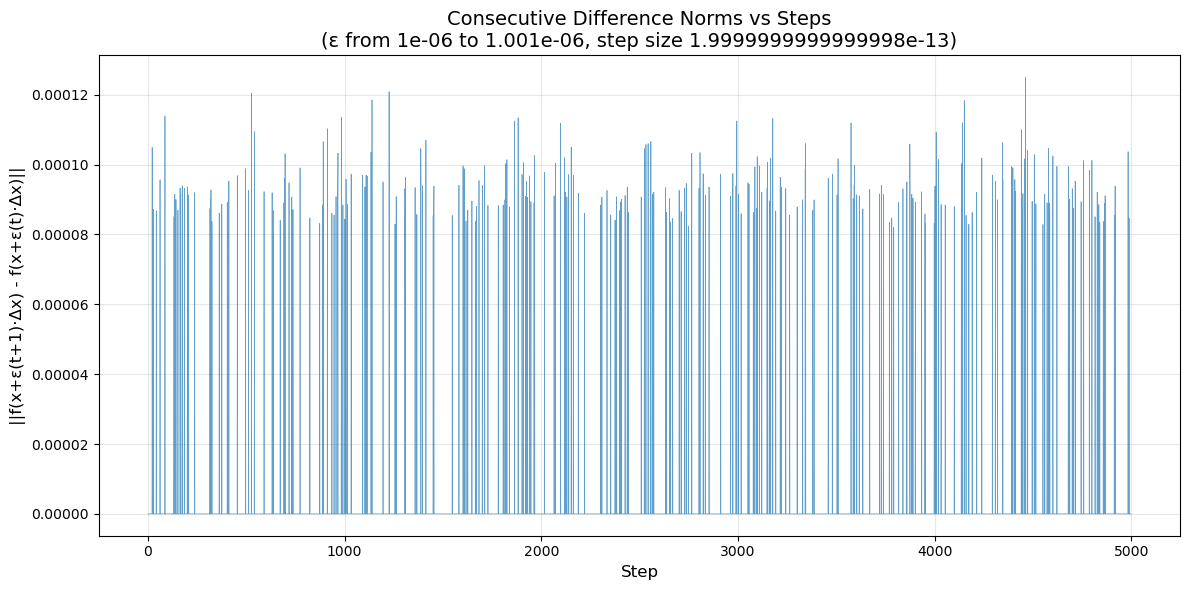

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

def load_model(model_path="/home/chashi/Desktop/Research/My Projects/models/Llama-3.1-8B-Instruct"):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map="auto",
        torch_dtype=torch.float32
    )
    return model, tokenizer

def compute_jacobian_svd(model, embeddings, last_token_idx):
    def forward_fn(flat_emb):
        emb = flat_emb.view(1, -1)
        mod_emb = embeddings.clone()
        mod_emb[0, last_token_idx, :] = emb
        outputs = model(inputs_embeds=mod_emb, output_hidden_states=True)
        return outputs.hidden_states[-1][0, last_token_idx, :]
    
    last_emb = embeddings[0, last_token_idx, :].clone().detach().requires_grad_(True)
    jacobian = torch.autograd.functional.jacobian(forward_fn, last_emb, vectorize=True)
    U, S, Vt = torch.linalg.svd(jacobian, full_matrices=False)
    return U, S, Vt

def get_hidden_state(model, embeddings, last_token_idx):
    with torch.no_grad():
        outputs = model(inputs_embeds=embeddings, output_hidden_states=True)
        hidden_state = outputs.hidden_states[-1][0, last_token_idx, :]
    return hidden_state

# Load model
print("Loading model...")
model, tokenizer = load_model()
device = next(model.parameters()).device

# Input
text = "The capital of France is"
inputs = tokenizer(text, return_tensors="pt").to(device)

with torch.no_grad():
    embeddings = model.model.embed_tokens(inputs["input_ids"])

last_idx = inputs["input_ids"].shape[1] - 1
original_input_emb = embeddings[0, last_idx, :].clone()

print(f"Input: '{text}'")
print("Computing SVD...")
U, S, Vt = compute_jacobian_svd(model, embeddings, last_idx)
direction_1 = Vt[0, :]
print(f"Singular value 1: {S[0].item():.6f}\n")

# Generate epsilon values from 10^-9 to 10^-8 with 10^-11 steps
epsilon_start = 1e-6
epsilon_end = (1e-6 + 1e-9)
epsilon_step = (1e-11/50)

# Create epsilon array
epsilons = []
eps = epsilon_start
while eps <= epsilon_end:
    epsilons.append(eps)
    eps += epsilon_step

epsilons = np.array(epsilons)
print(f"Number of epsilon values: {len(epsilons)}")
print(f"Epsilon range: {epsilons[0]:.2e} to {epsilons[-1]:.2e}\n")

# Storage for all data
all_input_embeddings = []
all_output_embeddings = []
difference_norms = []

# Compute outputs once per epsilon
print("Computing outputs for all epsilons...")
prev_output = None
prev_input = None

for i, eps in tqdm(enumerate(epsilons)):
    # Perturb input embedding
    current_input = original_input_emb + eps * direction_1
    
    # Get output
    perturbed_emb = embeddings.clone()
    perturbed_emb[0, last_idx, :] = current_input
    current_output = get_hidden_state(model, perturbed_emb, last_idx)
    
    # Store
    all_input_embeddings.append(current_input.cpu().numpy())
    all_output_embeddings.append(current_output.cpu().numpy())
    
    # Compute consecutive difference (if not first iteration)
    if prev_output is not None:
        diff_norm = torch.norm(current_output - prev_output).item()
        difference_norms.append(diff_norm)
    
    # Update previous
    prev_output = current_output
    prev_input = current_input
    
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{len(epsilons)} epsilons...")

# Convert to numpy arrays
all_input_embeddings = np.array(all_input_embeddings)
all_output_embeddings = np.array(all_output_embeddings)
difference_norms = np.array(difference_norms)

print(f"\nCompleted computation.")
print(f"Input embeddings shape: {all_input_embeddings.shape}")
print(f"Output embeddings shape: {all_output_embeddings.shape}")
print(f"Difference norms shape: {difference_norms.shape}")
print(f"\nDifference norm statistics:")
print(f"  Mean: {difference_norms.mean():.6e}")
print(f"  Std:  {difference_norms.std():.6e}")
print(f"  Min:  {difference_norms.min():.6e}")
print(f"  Max:  {difference_norms.max():.6e}")

experiment = '10^-6_to_10^-6+10^-9'
# Save embeddings to .npy files
print("\nSaving embeddings...")
np.save(f'input_embeddings_all_epsilons_{experiment}.npy', all_input_embeddings)
np.save(f'output_embeddings_all_epsilons_{experiment}.npy', all_output_embeddings)
print(f"  Saved: input_embeddings_all_epsilons_{experiment}.npy")
print(f"  Saved: output_embeddings_all_epsilons_{experiment}.npy")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(difference_norms)), difference_norms, linewidth=0.5, alpha=0.7)
plt.xlabel('Step', fontsize=12)
plt.ylabel('||f(x+ε(t+1)·Δx) - f(x+ε(t)·Δx)||', fontsize=12)
plt.title(f'Consecutive Difference Norms vs Steps\n(ε from {epsilon_start} to {epsilon_end}, step size {epsilon_step})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save as PDF
plt.savefig(f'consecutive_differences_{experiment}.pdf', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as 'consecutive_differences_{experiment}.pdf'")

# Also save complete data
np.savez(f'consecutive_differences_complete_{experiment}.npz',
         epsilons=epsilons,
         input_embeddings=all_input_embeddings,
         output_embeddings=all_output_embeddings,
         difference_norms=difference_norms,
         singular_value_1=S[0].cpu().numpy(),
         original_input_embedding=original_input_emb.cpu().numpy())
print(f"Complete data saved as 'consecutive_differences_complete_{experiment}.npz'")

plt.show()